In [53]:
# image processing
from PIL import Image
from io import BytesIO

# data analysis
import math
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
from importlib import reload
from mpl_toolkits import mplot3d
import seaborn as sns

# modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Image Detail

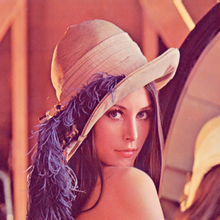

In [54]:
ori_img = Image.open("images/lena.png")
ori_img

In [55]:
X = np.array(ori_img.getdata())
ori_pixels = X.reshape(*ori_img.size, -1)
ori_pixels.shape

(220, 220, 3)

220 x 220 pixels with 3 channel RGB

In [56]:
ori_img_n_colors = len(set(ori_img.getdata()))
ori_img_n_colors

37270

Original image has 37270 unique colors.

In [57]:
def imageByteSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell()/1024

ori_img_size = imageByteSize(ori_img)
ori_img_size

85.99609375

Original image size: 86KB

# 3D Visualization
We can visualize each pixels in 3D plot based on the their RGB values. Here are the first 220 pixels, which represent the first row pixels in the image.

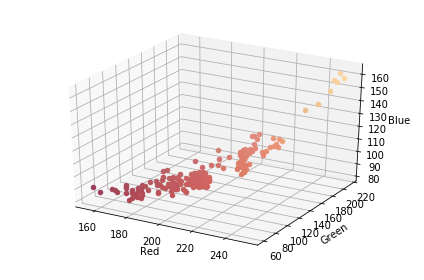

In [58]:
reload(plt)
fig = plt.figure("3-D Plot of Image")
ax = plt.axes(projection='3d')
for px in X[:220]:
    ax.scatter3D(*px, c = np.array([px])/255)
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.dist = 11
plt.tight_layout()
plt.show()

# Kmeans Clustering

## Idea

In [59]:
kmeans = KMeans(n_clusters = 2,
                n_jobs = -1,
                random_state = 123).fit(X)
pd.DataFrame(kmeans.cluster_centers_, columns = ['Red', 'Green', 'Blue'])

,Red,Green,Blue
0,130.542889,47.388621,77.450236
1,213.718313,133.891310,124.260309


Replace each pixels value in a cluster with its centroid value

In [60]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(*ori_img.size, -1)
    return new_pixels
new_pixels = replaceWithCentroid(kmeans)
new_pixels

array([[[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857]],

       [[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857]],

       [[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [130.54288939,  47.38862097,  77.45023599]],

       ...,

      

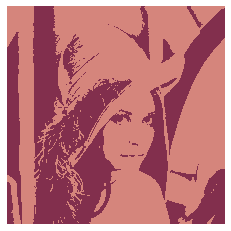

In [61]:
def plotImage(img_array, size):
    reload(plt)
    plt.imshow(np.uint8(img_array).reshape(*size))
    plt.axis('off')
    return plt
    
plotImage(new_pixels, new_pixels.shape).show()

In [62]:
imageByteSize(new_pixels)

4.3837890625

In [ ]:
ori_img_total_variance = np.linalg.norm(X - np.mean(X, axis = 0), axis = 1)**2
ori_img_total_variance

## Iterate

In [63]:
range_k_clusters = (2, 21)

kmeans_result = []
for k in range(*range_k_clusters):
    # clustering
    kmeans = KMeans(n_clusters = k,
                    n_jobs = -1,
                    random_state = 123).fit(X)
    
    # replace with centroid
    new_pixels = replaceWithCentroid(kmeans)
    
    # Calculate Between Cluster Sum of Square
    _, label_counts = np.unique(kmeans.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(kmeans.cluster_centers_ - np.mean(X, axis = 0), axis = 1)**2
    BCSS = sum(label_counts * diff_cluster_sq)
    
    metric = {
        "No. of Colors": k,
        "Centroids": kmeans.cluster_centers_,
        "Pixels": new_pixels,
        "WCSS": kmeans.inertia_,
        "BCSS": BCSS,
        "Total Variance": kmeans.inertia_ + BCSS,
        "Image Size (KB)": imageByteSize(new_pixels)
    }
    
    kmeans_result.append(metric)
kmeans_result = pd.DataFrame(kmeans_result).set_index("No. of Colors")
kmeans_result

,Centroids,Pixels,WCSS,BCSS,Total Variance,Image Size (KB)
No. of Colors,,,,,,
2,"[[130.5428893905358, 47.38862097270393, 77.450...","[[[213.71831326970442, 133.89131036391043, 124...",1.092607e+08,1.930717e+08,3.023324e+08,4.383789
3,"[[110.75055053536703, 35.51924975320544, 72.95...","[[[225.44421388667087, 167.00351157222383, 147...",6.079592e+07,2.416344e+08,3.024304e+08,6.662109
4,"[[101.76369371954503, 29.535799636743178, 69.8...","[[[212.22476813966176, 122.26475722858449, 114...",3.829205e+07,2.645456e+08,3.028376e+08,8.654297
5,"[[230.3257831325257, 189.56481927710567, 166.2...","[[[214.57149746804404, 134.9070010449294, 123....",2.953883e+07,2.729107e+08,3.024496e+08,10.584961
6,"[[143.7538265306115, 89.03869047619096, 129.61...","[[[216.79463980880337, 136.00623079549067, 122...",2.440947e+07,2.780032e+08,3.024127e+08,11.326172
7,"[[130.62918918918527, 50.59870270270022, 83.24...","[[[217.59388368070853, 137.3576954582662, 122....",2.088744e+07,2.813609e+08,3.022483e+08,13.569336
8,"[[94.12757850480178, 23.71501773748244, 65.466...","[[[213.39740529319698, 128.35910742085883, 117...",1.829728e+07,2.843931e+08,3.026903e+08,15.281250
9,"[[226.33964646464273, 156.76578282828027, 134....","[[[226.33964646464273, 156.76578282828027, 134...",1.623060e+07,2.864122e+08,3.026428e+08,16.035156
10,"[[234.86894215737001, 199.23293381969506, 173....","[[[227.54112013324607, 143.86445971267722, 121...",1.467699e+07,2.875256e+08,3.022026e+08,17.332031


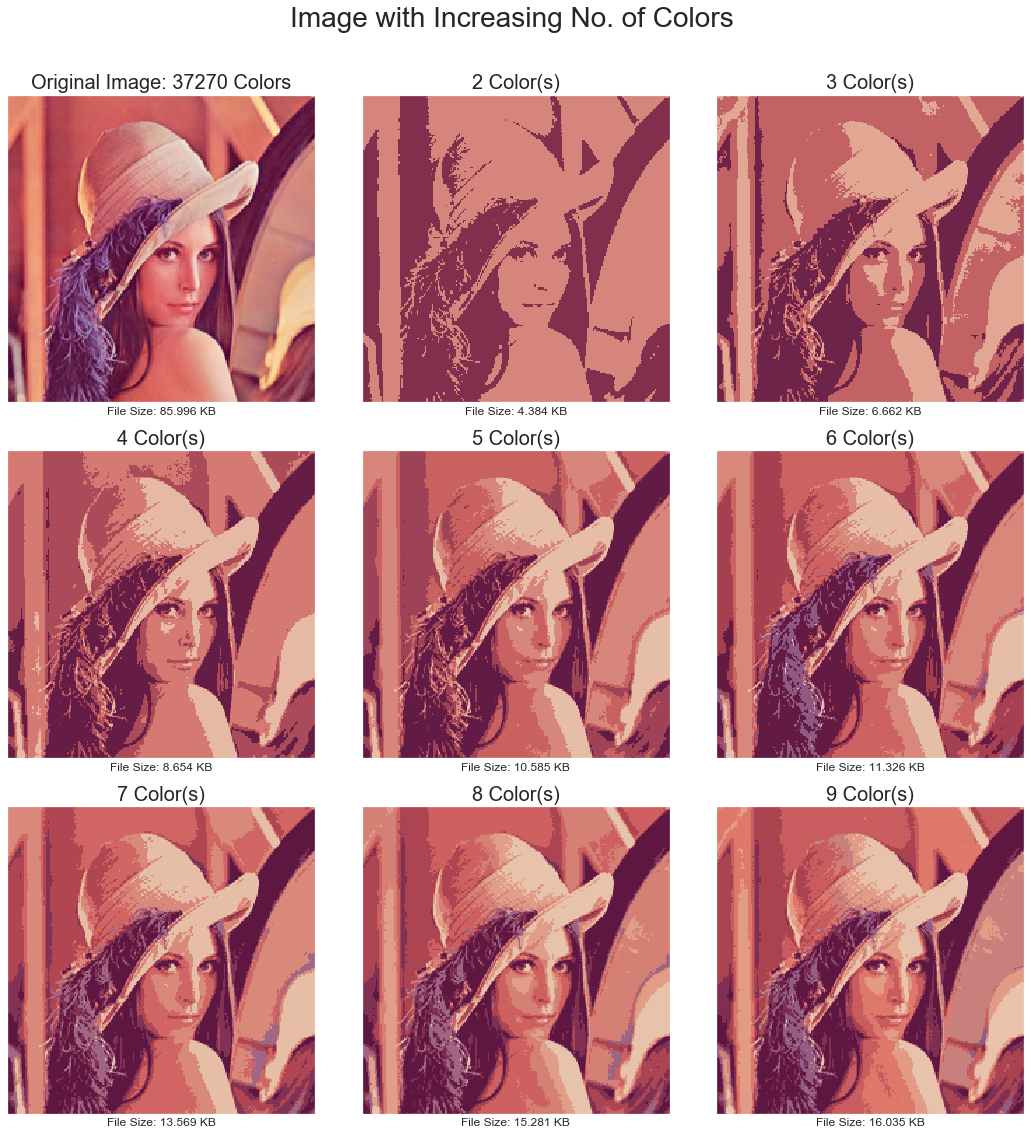

In [64]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=(15,15))

# PLOTTING ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image: {} Colors".format(ori_img_n_colors), fontsize = 20)
axes[0][0].set_xlabel("File Size: {:.3f} KB".format(ori_img_size))
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])

for ax, k, pixels in zip(axes.flat[1:], kmeans_result.index, kmeans_result["Pixels"]):
    compressed_image = np.array(pixels).reshape(*ori_img.size, 3)/255
    ax.imshow(compressed_image)
    ax.set_title("{} Color(s)".format(k), fontsize=20)
    ax.set_xlabel("File Size: {:.3f} KB".format(kmeans_result.loc[k, "Image Size (KB)"]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("Image with Increasing No. of Colors", size = 28, y = 1.05)
plt.show()

## Metric: Search for Optimal K
- Within cluster sum of square (WCSS)
- Silhouette Score: measures how similar a point is to its own cluster compared to other clusters. The range is between +1 and -1, where +1 is desirable and indicates that the point is placed in the correct cluster. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. Values near 0 indicate overlapping clusters.
- Image size in KB

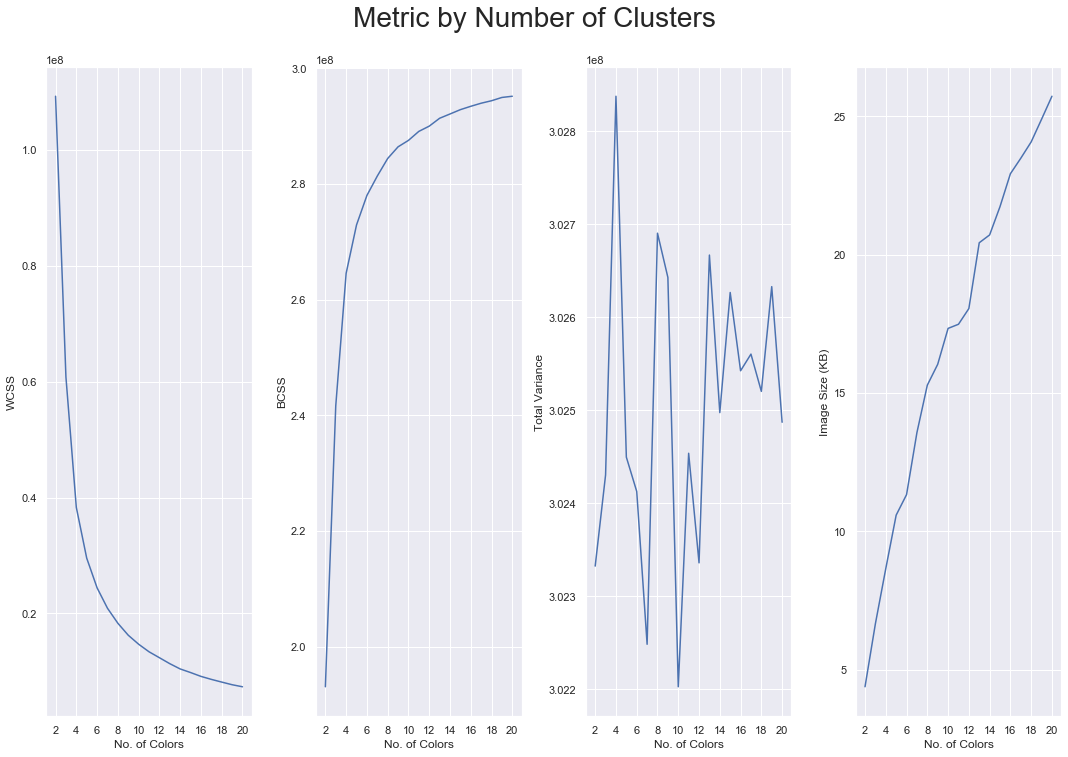

In [74]:
fig, axes = plt.subplots(1, 4, figsize=(20/,10))
for ax, metric in zip(axes, kmeans_result.columns[2:]):
    sns.lineplot(x = kmeans_result.index, y = metric, data = kmeans_result, ax = ax)
    ax.set_xticks(kmeans_result.index[::2])
plt.tight_layout()
fig.suptitle("Metric by Number of Clusters", size = 28, y = 1.05)
plt.show()

Using furthest distance from line to locate optimal elbow

In [66]:
def locateOptimalElbow(x, y):
    # START AND FINAL POINTS
    p1 = (x[0], y[0])
    p2 = (x[-1], y[-1])
    
    # EQUATION OF LINE: GRADIENT AND CONSTANT
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = (p2[1] - (m * p2[0]))
    
    # DISTANCE FROM POINTS TO LINE
    a, b = m, -1
    dist = np.array([abs(a*x0+b*y0+c)/math.sqrt(a**2+b**2) for x0, y0 in zip(x,y)])
    return np.argmax(dist) + x[0]

Using second derivative to locate the most drastic change in gradient

In [67]:
def calculateDerivative(data):
    derivative = []
    for i in range(len(data)):
        if i == 0:
            # FORWARD DIFFERENCE
            d = data[i+1] - data[i]
        elif i == len(data) - 1:
            # BACKWARD DIFFERENCE
            d = data[i] - data[i-1]
        else:
            # CENTER DIFFERENCE
            d = (data[i+1] - data[i-1])/2
        derivative.append(d)
    return np.array(derivative)

def locateDrasticChange(x, y):
    # CALCULATE GRADIENT BY FIRST DERIVATIVE
    first_derivative = calculateDerivative(np.array(y))
    
    # CALCULATE CHANGE OF GRADIENT BY SECOND DERIVATIVE
    second_derivative = calculateDerivative(first_derivative)

    return np.argmax(np.abs(second_derivative)) + x[0]

In [68]:
k_opt_by_WCSS = locateOptimalElbow(kmeans_result.index, kmeans_result["WCSS"].values)
k_opt_by_WCSS

5

In [71]:
k_opt_by_BCSS = locateOptimalElbow(kmeans_result.index, kmeans_result["BCSS"].values)
k_opt_by_BCSS

5

In [72]:
k_opt_by_var = locateDrasticChange(kmeans_result.index, kmeans_result["Total Variance"].values)
k_opt_by_var

4

In [69]:
k_opt_by_size = locateDrasticChange(kmeans_result.index, kmeans_result["Image Size (KB)"].values)
k_opt_by_size

12

In [70]:
k_opt_range = (k_opt_by_WCSS, k_opt_by_size)
k_opt_by_silhouette = kmeans_result.loc[min(k_opt_range):max(k_opt_range), "Silhouette Score"].idxmax()
k_opt_by_silhouette

KeyError: 'Silhouette Score'

## Compare to Original Image

In [ ]:
ori = {
    "Type": "Original",
    "Pixels": X,
    "Colors": ori_img_n_colors,
    "Size": ori_img_size
}
reduced = {
    "Type": "Color-Reduced",
    "Pixels": kmeans_result.loc[k_opt_by_silhouette, "Pixels"],
    "Colors": k_opt_by_silhouette,
    "Size": kmeans_result.loc[k_opt_by_silhouette, "Image Size (KB)"]
}
ori_vs_reduced = pd.DataFrame([ori, reduced]).set_index("Type")
ori_vs_reduced

In [ ]:
size_reduction = (ori_vs_reduced.loc["Original", "Size"]-ori_vs_reduced.loc["Color-Reduced", "Size"])/ori_vs_reduced.loc["Original", "Size"] * 100
print("Size: {:.3f}% of original image size".format(ori_vs_reduced.loc["Color-Reduced", "Size"]/ori_vs_reduced.loc["Original", "Size"] * 100))
print("Reduction: {:.3f}%".format(size_reduction))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
for ax, k, pixels, size in zip(axes.flat, ori_vs_reduced["Colors"], ori_vs_reduced["Pixels"], ori_vs_reduced["Size"]):
    img_array = np.array(pixels)/255
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("{} colors ({:.3f} KB)".format(k, size), fontsize=20)
plt.tight_layout()
fig.suptitle("Original Image vs Color-Reduced Image", size = 28, y = 1.1)
plt.show()

# Pricinpal Component Analysis

## Principal Components of RGB

In [ ]:
res = []
cum_var = []
X_t = np.transpose(X)
for channel in range(3):
    # ORIGINAL RGB PIXEL
    pixel = X_t[channel].reshape(*ori_pixels.shape[:2])
    
    # PCA
    pca = PCA(random_state = 123)
    pixel_pca = pca.fit_transform(pixel)
    
    pca_dict = {
        "Pixel": pixel_pca,
        "Components": pca.components_,
        "Mean": pca.mean_
    }
    res.append(pca_dict)
    
    # EVALUATION
    cum_var.append(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
scaler = MinMaxScaler()
scaled_pixels = [scaler.fit_transform(res[i]["Components"])*255 for i in range(3)]

fig, axes = plt.subplots(1, 4, figsize=(15,5))
cmap_list = ["Reds", "Greens", "Blues"]

axes[0].imshow(np.uint8(scaled_pixels).T)
axes[0].axis("off")
axes[0].set_title("Combined", size = 15)

for idx, ax, px in zip(range(3), axes[1:], scaled_pixels):
    ax.imshow(np.uint8(px).T, cmap = cmap_list[idx])
    ax.axis("off")
    ax.set_title(cmap_list[idx][:-1], size = 15)
plt.tight_layout()
fig.suptitle("Principal Components of Each Color Channel", size = 25, y = 1)
plt.show()

## Cumulative Explained Variance

In [ ]:
cum_var_df = pd.DataFrame(np.array(cum_var).T * 100, 
                          index = range(1, pca.n_components_+1),
                          columns = ["Explained Variance by Red",
                                     "Explained Variance by Green",
                                     "Explained Variance by Blue"])
cum_var_df["Explained Variance"] = cum_var_df.mean(axis = 1)
cum_var_df

## Iterate

In [ ]:
pca_results = []
for n in range(1, pca.n_components_+1):
    # SELECT N-COMPONENTS FROM PC
    temp_res = []
    for channel in range(3):
        pca_channel = res[channel]
        pca_pixel = pca_channel["Pixel"][:, :n]
        pca_comp = pca_channel["Components"][:n, :]
        pca_mean = pca_channel["Mean"]
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca_mean
        temp_res.append(compressed_pixel.T)
    compressed_image = np.transpose(temp_res)
    
    pca_dict = {
        "n": n,
        "Pixel": compressed_image,
        "Explained Variance": cum_var_df["Explained Variance"][n],
        "Image Size (KB)": imageByteSize(compressed_image),
        "No. of Colors": len(np.unique(np.uint8(compressed_image).reshape(-1, 3), axis = 0))
    }
    
    pca_results.append(pca_dict)

pca_results = pd.DataFrame(pca_results).set_index("n")
pca_results.head()

In [ ]:
n_pca_images = (3, 4)
end_pc = np.where(pca_results["Explained Variance"] >= 95)[0][0]

fig, axes = plt.subplots(*n_pca_images, figsize=(15,10))
plot_n = np.linspace(1, end_pc, n_pca_images[0]*n_pca_images[1]-1, endpoint = True, dtype = int) 

# PLOTTING ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image", fontsize = 20)
axes[0][0].set_xlabel("File Size: {:.3f} KB".format(ori_img_size))
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
        
for ax, n in zip(axes.flat[1:], plot_n):
    # PLOTTING COMPRESSED IMAGE
    ax.imshow(np.uint8(pca_results.loc[n, "Pixel"]))
    ax.set_title("{} Principal Component(s)".format(n), fontsize = 20)
    ax.set_xlabel("{:.3f}% Explained Variance\nFile Size: {:.3f} KB".format(pca_results.loc[n, "Explained Variance"],
                                                                            pca_results.loc[n, "Image Size (KB)"]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("Image with Increasing No. of Principal Components", size = 28, y = 1.05)
plt.show()

## Metric: Search for Optimal No. of PCs

In [ ]:
line_colors = "yrk"
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, metric in zip(axes, pca_results.columns[1:]):
    sns.lineplot(x = pca_results.index, y = metric, data = pca_results, ax = ax)
    
    if metric == "Explained Variance":
        for idx, exp_var in enumerate([90, 95, 99]):
            lookup_n = np.where(pca_results[metric] >= exp_var)[0][0]
            ax.axhline(y = exp_var, color = line_colors[idx], linestyle = '--',
                       label = "{}% Explained Variance (n = {})".format(exp_var, lookup_n))
            ax.plot(lookup_n, exp_var, color = line_colors[idx], marker = 'x', markersize = 8)
            ax.set_ylabel("Cumulative Explained Variance (%)")
    elif metric == "Image Size (KB)":
        for idx, img_size_percent in enumerate([50, 75, 100]):
            lookup_img_size = img_size_percent/100*ori_img_size
            lookup_n = np.where(pca_results[metric] >= lookup_img_size)[0][0]
            ax.axhline(y = lookup_img_size, color = line_colors[idx], linestyle = '--',
                       label = "{}% Original Image Size (n = {})".format(img_size_percent, lookup_n))
            ax.plot(lookup_n, lookup_img_size, color = line_colors[idx], marker = 'x', markersize = 8)
    else:
        ax.axhline(y = ori_img_n_colors, color = 'k', linestyle = '--',
                   label = "Original Image")
    ax.set_xlabel("No. of Principal Components")
    ax.legend()
plt.tight_layout()
fig.suptitle("Metric by Number of Principal Components", size = 25, y = 1.05)
plt.show()

# Compare

In [ ]:
pca_results["No. of Colors"]

# Conclusion